# Mine into subgroup 1. Extract minigroups with high concentration of PHAs

In [1]:
%matplotlib inline
import string
import math
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle, sys, os, time
import numpy as np
import pydotplus
import pandas as pd
import scipy.stats as ss
from sklearn import neighbors, svm
from sklearn.neighbors.kde import KernelDensity
from sklearn import preprocessing as pp
from sklearn import tree

import read_database as rdb
import generate_orbits as go
import learn_data as ld
import visualize_data as vd
import asterion_learn as al
from  copy import deepcopy

font = {'size': 14}
mpl.rc('font', **font)

**Prepare plot labels**

** Load 1st subgroup of generated asteroids and all real apollo asteroids **

In [2]:
dumps_gen_sg1 = ['./asteroid_data/haz_gen_sg1.p', 
                 './asteroid_data/nohaz_gen_sg1.p',
                 './asteroid_data/haz_gen_sg1_rest.p', 
                 './asteroid_data/nohaz_gen_sg1_rest.p']
            
dumps_genu = ['./asteroid_data/haz_genu_sg1.p', 
              './asteroid_data/nohaz_genu_sg1.p',
              './asteroid_data/haz_genu_sg1_rest.p', 
              './asteroid_data/nohaz_genu_sg1_rest.p']
         
dumps_real = ['./asteroid_data/haz_test.p', 
              './asteroid_data/nohaz_test.p']

haz_gen, nohaz_gen, haz_gen_rest, nohaz_gen_rest = map(rdb.loadObject, dumps_gen_sg1)
haz_genu, nohaz_genu, haz_genu_rest, nohaz_genu_rest = map(rdb.loadObject, dumps_genu)

# haz_real, nohaz_real = map(rdb.loadObject, dumps_real)
# haz_gen_full = rdb.loadObject('./asteroid_data/haz_rand_2e5.p')
# nohaz_gen_full = rdb.loadObject('./asteroid_data/nohaz_rand_2e5.p')

** Investigate distributions of orbital parameters for the 1st subgroup **

In [3]:
datasets_gen = [haz_gen, nohaz_gen]
datasets_genu = [haz_genu, nohaz_genu]
datasets_real = [haz_real, nohaz_real]

In [4]:
# reload(vd)
# vd.display_allparams(datasets_gen, vd.combs, vd.colnames)

## Apply simple cut by tree by semi-major axis and inclination

In [5]:
# haz_train_cut, nohaz_train_cut = ld.prepare_data(cutcol=['a', 'i'], datasets=[haz_gen, nohaz_gen])
# xtrain, ytrain, xtest, ytest = ld.get_learndata([haz_train_cut, nohaz_train_cut, haz_test_cut, nohaz_test_cut])

# reload(ld)
cutcol = ['a', 'i']
xtrain, ytrain = ld.learning_sets(haz_gen, nohaz_gen, cutcol)
clf = tree.DecisionTreeClassifier(max_depth=2) 
clf = clf.fit(xtrain, ytrain)

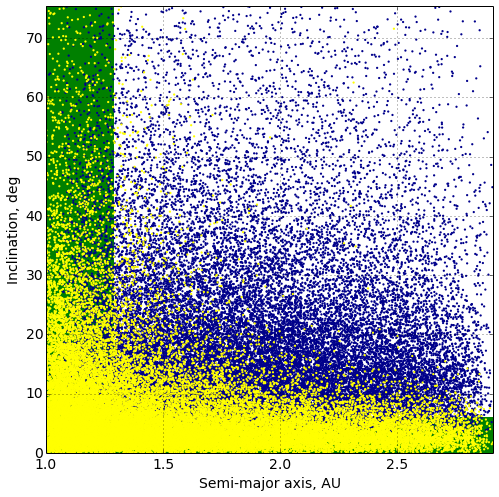

In [8]:
# reload(vd)
# haz_gen_cut, nohaz_gen_cut = ld.prepare_data(cutcol=cutcol, datasets=[haz_gen, nohaz_gen])
haz_gen_cut, nohaz_gen_cut = ld.cut_2params(cutcol, [haz_gen, nohaz_gen])
labels = [vd.colnames['a'], vd.colnames['i']]
# vd.plot_classifier(xtrain, clf,  cmap='ocean_r', labels=labels, rescale=False)
vd.plot_classifier(xtrain, clf, cmap='ocean_r', haz=haz_gen_cut, nohaz=nohaz_gen_cut, 
                   labels=labels, rescale=False, figsize=(8,8))

In [9]:
al.fit_predict(xtrain, ytrain, xtrain, ytrain, clf)

score: 0.817037881445
predict_haz_fraction: 0.474541096691
true_haz_fraction: 0.48317841693


In [10]:
haz_predicted = clf.predict(haz_gen_cut)
nohaz_predicted = clf.predict(nohaz_gen_cut)

haz_num = len(np.where(haz_predicted == 1)[0])
nohaz_num = len(np.where(nohaz_predicted == 1)[0])
purity = float(haz_num)/(haz_num + nohaz_num)
print purity

0.81632275947


## Split subgroup into 2 minigroups by the density of nonhazardous asteroids

In [11]:
# cutcol = ['a', 'i']
# labels = [vd.colnames['a'], vd.colnames['i']]
# vd.display_param2d(cutcol, labels, [haz_gen, nohaz_gen]) #invertaxes=[0,1]

** Cut w and q **

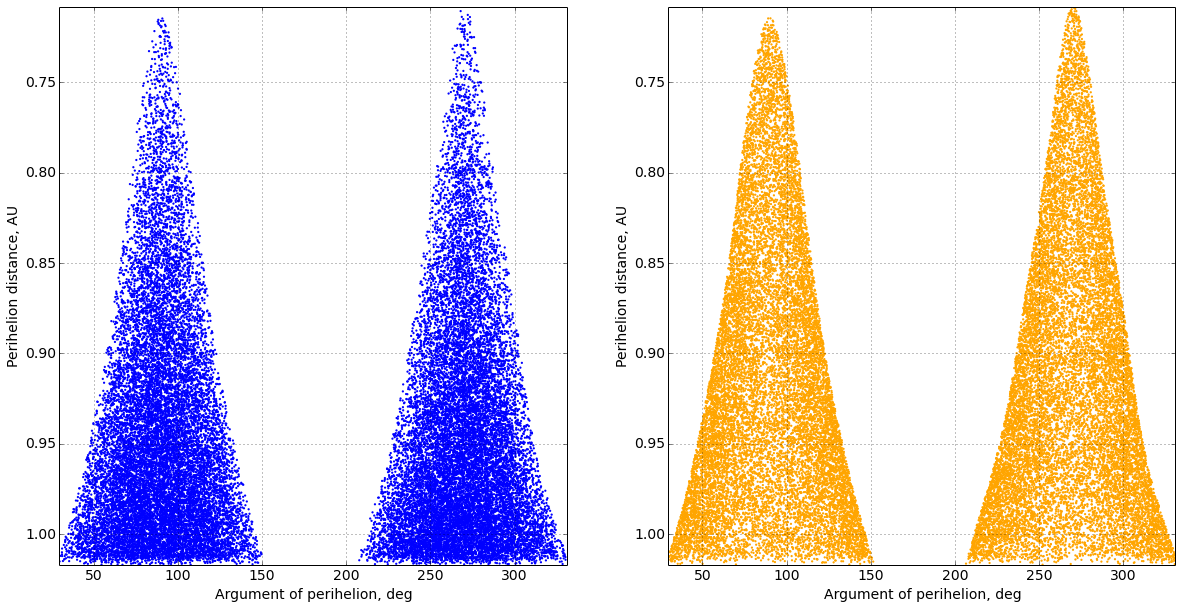

In [12]:
cutcol = ['w', 'q']
labels = [vd.colnames['w'], vd.colnames['q']]
vd.display_param2d(cutcol, labels, [haz_gen, nohaz_gen], invertaxes=[0,1]) #invertaxes=[0,1]

** Normalize datasets **

In [13]:
haz_gen_cut, nohaz_gen_cut = ld.cut_2params(cutcol, [haz_gen, nohaz_gen])
haz_gen_cutn, haz_sc = al.normalize_dataset(haz_gen_cut)
nohaz_gen_cutn, nohaz_sc = al.normalize_dataset(nohaz_gen_cut)

** Find common scale **

In [14]:
xsc = np.asarray([list(ss[0]) for ss in [haz_sc, nohaz_sc]]).ravel()
ysc = np.asarray([list(ss[1]) for ss in [haz_sc, nohaz_sc]]).ravel()
scales = [(xsc.min(), xsc.max()), (ysc.min(), ysc.max())]

** Extend nonhazardous dataset with narrow bands on the top to get better KDE fit **

In [15]:
def gen_strips(amounts, bounds):
    strips = []
    for a, b in zip(amounts, bounds):
        h, v = a
        right, left, bottom, top = b
        
        hrand = np.array([np.random.uniform(low=left, high=right, size=v) for i in range(h)])
        vrand = np.array([np.random.uniform(low=bottom, high=top, size=h) for i in range(v)]).T
        
        hrand_ = hrand.ravel().T
        vrand_ = vrand.ravel().T
        
        rand_strip = np.concatenate((hrand_, vrand_)).reshape(2, len(vrand_)).T
        strips.append(rand_strip)
    return strips

In [16]:
am1 = [250, 7]
sb1 = [-0.02, 0.42, 0.99, 1.04]
sb2 = [0.58,  1.02, 0.99, 1.04]
sb3 = [0.04,  0.36, 0.99, 1.04]
sb4 = [0.64,  0.96, 0.99, 1.04]

am2 = [250, 7]
sb5 = [-0.04, 0.44, 1.04, 1.09]
sb6 = [0.56,  1.04, 1.04, 1.09]
sb7 = [0.02,  0.38, 1.04, 1.09]
sb8 = [0.62,  0.98, 1.04, 1.09]

am3 = [200, 10]
sb9 = [-0.02, 0.42, 1.09, 1.2]
sb10 = [0.58, 1.02, 1.09, 1.2]
sb11 = [0.04, 0.36, 1.09, 1.2]
sb12 = [0.64, 0.96, 1.09, 1.2]

# strips = gen_strips([am12, am12], [sb1, sb2])
# strips = gen_strips([am34, am34], [sb3, sb4])
# strips = gen_strips([am12, am12, am34, am34], [sb1, sb2, sb3, sb4])
# strips = gen_strips([am56, am56], [sb5, sb6])
# strips = gen_strips([am78, am78], [sb7, sb8])
strips = gen_strips([am1, am1, am1, am1, am2, am2, am2, am2, am3, am3, am3, am3], 
                    [sb1, sb2, sb3, sb4, sb5, sb6, sb7, sb8, sb9, sb10, sb11, sb12])

In [17]:
extended = [nohaz_gen_cutn] + strips
nohaz_gen_cutn_ = np.concatenate(tuple(extended))

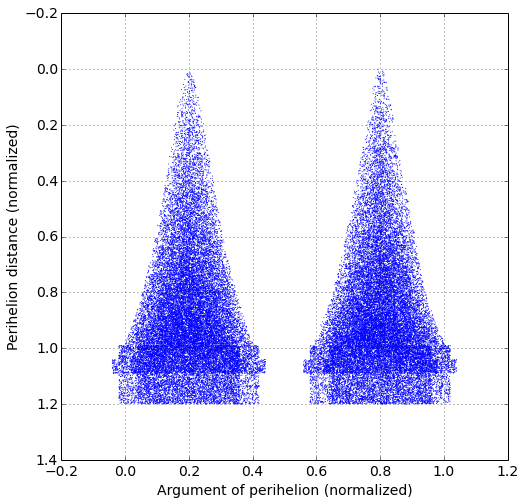

In [20]:
labels_norm = [vd.colnames_norm['w'], vd.colnames_norm['q']]
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.scatter(nohaz_gen_cutn_[..., 0], nohaz_gen_cutn_[..., 1], s=1, lw=0)
ax.set_xlabel(labels_norm[0])
ax.set_ylabel(labels_norm[1])
ax.grid(True)
ax.invert_yaxis()
plt.show()

** Fit Kernel Density model based on density distribution for nonhazardous dataset **

In [21]:
kde = KernelDensity(kernel='linear', bandwidth=0.1).fit(nohaz_gen_cutn_)
# kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(nohaz_gen_cutn_)
# reload(al)
levels, xyz = al.normgrid_kde(kde, levnum=4, scales=scales)

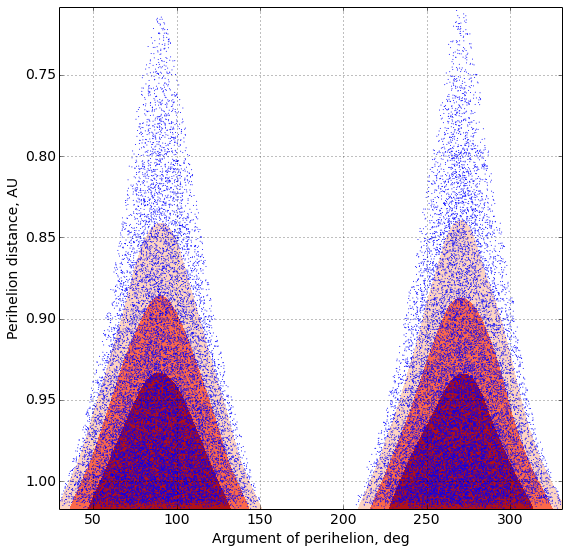

In [23]:
x, y, z = xyz
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
ax.contourf(x, y, z, levels=levels, cmap=plt.cm.Reds)
ax.scatter(nohaz_gen_cut[..., 0], nohaz_gen_cut[..., 1], s=1, lw=0)
ax.grid(True)
ax.set_xlim(scales[0])
ax.set_ylim(scales[1])
ax.set_xlabel(labels[0])
ax.set_ylabel(labels[1])
ax.invert_yaxis()
plt.show()
# reload(vd)
# vd.plot_kde(kde, levnum=4, figsize=(10,10), scales=scales)

In [24]:
Zhaz = kde.score_samples(haz_gen_cutn)
Znohaz = kde.score_samples(nohaz_gen_cutn)

** Split datasets by density clusters **

In [25]:
mingi_haz = al.split_minigroups(Zhaz, levels)
mingi_nohaz = al.split_minigroups(Znohaz, levels)

In [26]:
haz_mg11_inds = mingi_haz[-1]
nohaz_mg11_inds = mingi_nohaz[-1]
haz_gen_mg11 = haz_gen.iloc[haz_mg11_inds] #  + mingi_haz[1]
nohaz_gen_mg11 = nohaz_gen.iloc[nohaz_mg11_inds] #  + mingi_nohaz[1]

haz_mg12_inds = mingi_haz[-2] # + mingi_haz[-3] + mingi_haz[-4]
nohaz_mg12_inds = mingi_nohaz[-2] # + mingi_nohaz[-3] + mingi_nohaz[-4]
haz_gen_mg12 = haz_gen.iloc[haz_mg12_inds]
nohaz_gen_mg12 = nohaz_gen.iloc[nohaz_mg12_inds]

haz_rest_inds = list(set(range(len(haz_gen))) - set(haz_mg11_inds + haz_mg12_inds))
nohaz_rest_inds = list(set(range(len(nohaz_gen))) - set(nohaz_mg11_inds + nohaz_mg12_inds))

haz_gen_mg13 = haz_gen.iloc[haz_rest_inds]
nohaz_gen_mg13 = nohaz_gen.iloc[nohaz_rest_inds]

In [27]:
def split_minigroup(haz_mg, nohaz_mg, clf, cutcol):
    
    haz_cut, nohaz_cut = ld.cut_2params(cutcol, [haz_mg, nohaz_mg])
    
    haz_predicted = clf.predict(haz_cut)
    nohaz_predicted = clf.predict(nohaz_cut)
    
    haz_extr_inds = np.where(haz_predicted == 1)[0]
    haz_rest_inds = np.where(haz_predicted == 0)[0]

    nohaz_extr_inds = np.where(nohaz_predicted == 1)[0]
    nohaz_rest_inds = np.where(nohaz_predicted == 0)[0]
    
    haz_num = len(haz_extr_inds)
    nohaz_num = len(nohaz_extr_inds)
    purity = float(haz_num)/(haz_num + nohaz_num)
    print "purity:", purity
    
    haz_mg_extr = haz_mg.iloc[haz_extr_inds]
    nohaz_mg_extr = nohaz_mg.iloc[nohaz_extr_inds]
    
    haz_mg_rest = haz_mg.iloc[haz_rest_inds]
    nohaz_mg_rest = nohaz_mg.iloc[nohaz_rest_inds]
    
    return haz_mg_extr, nohaz_mg_extr, haz_mg_rest, nohaz_mg_rest
  

## Mine minigroup 1.1

In [28]:
# vd.display_allparams([haz_gen_mg11, nohaz_gen_mg11], vd.combs, vd.colnames)

** Apply simple cut **

In [29]:
cutcol = ['a', 'i']
xtrain_mg11, ytrain_mg11 = ld.learning_sets(haz_gen_mg11, nohaz_gen_mg11, cutcol)
clf11 = tree.DecisionTreeClassifier(max_depth=2) 
clf11 = clf11.fit(xtrain_mg11, ytrain_mg11)

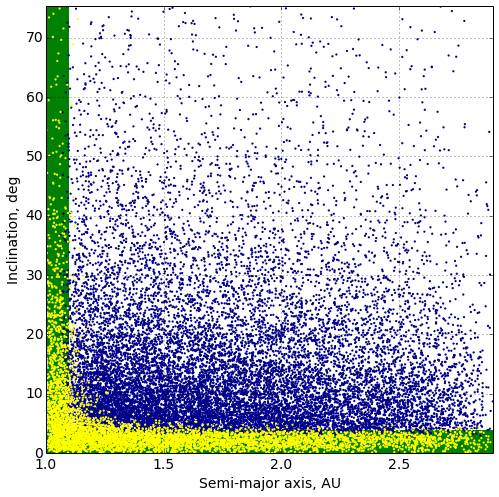

In [31]:
haz_gen_mg11_cut, nohaz_gen_mg11_cut = ld.cut_2params(cutcol, [haz_gen_mg11, nohaz_gen_mg11])
labels = [vd.colnames['a'], vd.colnames['i']]
vd.plot_classifier(xtrain_mg11, clf11, haz=haz_gen_mg11_cut, nohaz=nohaz_gen_mg11_cut, cmap='ocean_r', 
                   labels=labels, invertaxes=[0,0], rescale=False, figsize=(8,8))

** Analyse prediction score **

In [32]:
al.fit_predict(xtrain_mg11, ytrain_mg11, xtrain_mg11, ytrain_mg11, clf11)

score: 0.944914420618
predict_haz_fraction: 0.260722014558
true_haz_fraction: 0.258459571119


** Analyse split quality for minigroup 1.1**

In [33]:
extract11 = split_minigroup(haz_gen_mg11, nohaz_gen_mg11, clf11, cutcol)
haz_gen_mg11_extr, nohaz_gen_mg11_extr, haz_gen_mg11_rest, nohaz_gen_mg11_rest = extract11

purity: 0.890020750802


## Mine minigroup 1.2

In [34]:
# vd.display_allparams([haz_gen_mg12, nohaz_gen_mg12], vd.combs, vd.colnames)

** Apply simple cut **

In [35]:
cutcol = ['a', 'i']
xtrain_mg12, ytrain_mg12 = ld.learning_sets(haz_gen_mg12, nohaz_gen_mg12, cutcol)
clf12 = tree.DecisionTreeClassifier(max_depth=2) 
clf12 = clf12.fit(xtrain_mg12, ytrain_mg12)

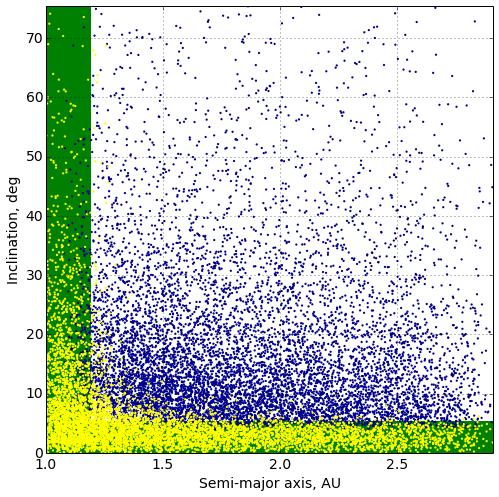

In [37]:
haz_gen_mg12_cut, nohaz_gen_mg12_cut = ld.cut_2params(cutcol, [haz_gen_mg12, nohaz_gen_mg12])
labels = [vd.colnames['a'], vd.colnames['i']]
vd.plot_classifier(xtrain_mg12, clf12, haz=haz_gen_mg12_cut, nohaz=nohaz_gen_mg12_cut, cmap='ocean_r', 
                   labels=labels, invertaxes=[0,0], rescale=False, figsize=(8,8))

**Analyse prediction score**

In [38]:
al.fit_predict(xtrain_mg12, ytrain_mg12, xtrain_mg12, ytrain_mg12, clf12)

score: 0.920200785121
predict_haz_fraction: 0.415921230452
true_haz_fraction: 0.420812150074


** Analyze split quality for minigroup 1.2**

In [39]:
extract12 = split_minigroup(haz_gen_mg12, nohaz_gen_mg12, clf12, cutcol)
haz_gen_mg12_extr, nohaz_gen_mg12_extr, haz_gen_mg12_rest, nohaz_gen_mg12_rest = extract12

purity: 0.909948940121


## Mine minigroup 1.3

In [40]:
# vd.display_allparams([haz_gen_mg13, nohaz_gen_mg13], vd.combs, vd.colnames)

** Apply simple cut **

In [41]:
cutcol = ['a', 'i']
xtrain_mg13, ytrain_mg13 = ld.learning_sets(haz_gen_mg13, nohaz_gen_mg13, cutcol)
clf13 = tree.DecisionTreeClassifier(max_depth=2) 
clf13 = clf13.fit(xtrain_mg13, ytrain_mg13)

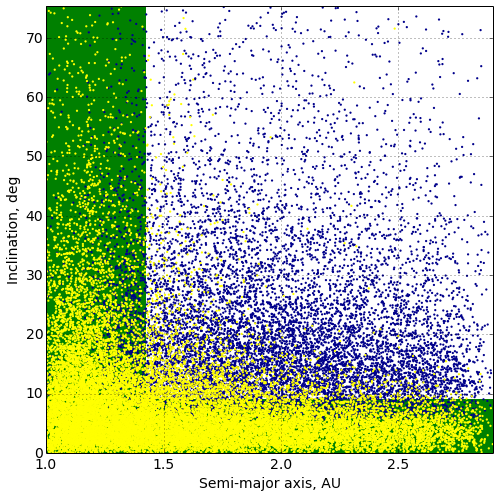

In [42]:
haz_gen_mg13_cut, nohaz_gen_mg13_cut = ld.cut_2params(cutcol, [haz_gen_mg13, nohaz_gen_mg13])
labels = [vd.colnames['a'], vd.colnames['i']]
vd.plot_classifier(xtrain_mg13, clf13, haz=haz_gen_mg13_cut, nohaz=nohaz_gen_mg13_cut, cmap='ocean_r', 
                   labels=labels, invertaxes=[0,0], rescale=False, figsize=(8,8))

**Analyse prediction score**

In [43]:
al.fit_predict(xtrain_mg13, ytrain_mg13, xtrain_mg13, ytrain_mg13, clf13)

score: 0.868552821553
predict_haz_fraction: 0.656959420023
true_haz_fraction: 0.653303842964


** Analyze split quality for minigroup 1.3**

In [44]:
extract13 = split_minigroup(haz_gen_mg13, nohaz_gen_mg13, clf13, cutcol)
haz_gen_mg13_extr, nohaz_gen_mg13_extr, haz_gen_mg13_rest, nohaz_gen_mg13_rest = extract13

purity: 0.897175722435


## Export minigroups

In [45]:
haz_mg_db = [haz_gen_mg11, haz_gen_mg12, haz_gen_mg13]
nohaz_mg_db = [nohaz_gen_mg11, nohaz_gen_mg12, nohaz_gen_mg13]

haz_mg_extr_db = [haz_gen_mg11_extr, haz_gen_mg12_extr, haz_gen_mg13_extr]
nohaz_mg_extr_db = [nohaz_gen_mg11_extr, nohaz_gen_mg12_extr, nohaz_gen_mg13_extr]

haz_mg_rest_db = [haz_gen_mg11_rest, haz_gen_mg12_rest, haz_gen_mg13_rest]
nohaz_mg_rest_db = [nohaz_gen_mg11_rest, nohaz_gen_mg12_rest, nohaz_gen_mg13_rest]

In [46]:
def dump_minigroups(haz_dbs, nohaz_dbs, prefix):
    dirpath = './asteroid_data/'
    basenames = ['gen_mg11', 'gen_mg12', 'gen_mg13']
    for haz, nohaz, basename in zip(haz_dbs, nohaz_dbs, basenames):
        hazpath = dirpath + 'haz_' + basename + prefix + '.p'
        nohazpath = dirpath + 'nohaz_' + basename + prefix + '.p'
        rdb.dumpObject(haz, hazpath)
        rdb.dumpObject(nohaz, nohazpath)

In [47]:
prefixes = ['', '_extr', '_rest']
haz_dbs = [haz_mg_db, haz_mg_extr_db, haz_mg_rest_db]
nohaz_dbs = [nohaz_mg_db, nohaz_mg_extr_db, nohaz_mg_rest_db]

dumpall = [dump_minigroups(haz, nohaz, prefix) 
           for haz, nohaz, prefix in zip(haz_dbs, nohaz_dbs, prefixes)]

## Plot desision boundaries for minigroups in a-i space

In [51]:
# reload(vd)
# labels = [vd.colnames['a'], vd.colnames['i']]
# vd.plot_onegroup(xtrain_mg11, clf11, -4, [-4.0, 0.0], labels=labels, figsize=(8,8))

In [52]:
# vd.plot_onegroup(xtrain_mg12, clf12, -3, [-4.0, 0.0], labels, figsize=(8,8))

In [53]:
# vd.plot_onegroup(xtrain_mg13, clf13, -2, [-4.0, 0.0], labels=labels, figsize=(8,8))